# Stochastic VO2 Array Simulations

In [1]:
import matplotlib.pyplot as plt;
import numpy;
import cmath;
import math;
import pandas as pd;
from pylab import *;
import os;

import bisect;

from scipy.special import jv, yv;
from scipy.special import jv, yv;
from scipy.signal import argrelextrema, argrelmin, argrelmax, find_peaks_cwt, medfilt, savgol_filter
from scipy.interpolate import interp2d

%matplotlib inline

#from bokeh.plotting import line, show, figure;
#from bokeh.plotting import output_notebook;
#output_notebook();

from mpl_toolkits.axes_grid1 import make_axes_locatable;
import matplotlib.patheffects as path_effects;

In [2]:
# Define the importFDTD() function()
# which takes the URL of a matrix with data in the [0,key;wavelength,data] format and returns a Pandas Dataframe object

def importFDTD(URL):
    # URL = string containing the file URL
    # Returns the imported data file
    
    data = pd.read_table(URL, header = 0);
    #data = data.set_index('0'); #set correct index
    
    # data.columns.values gives a vector containing keys
    # data.index.values gives a vector containing the wavelengths
    # data['key'].values gives a vector containing the data for the given key
    
    return data;

# Define the filterData() function
# which takes the raw data and returns the filtered data
def filterData(data, window):
    # apply a median filter with the given window
    # then apply a sovitsky-golay fitler with the given window, and a polynomial order of 3
    
    data = medfilt(data, window);
    data = savgol_filter(data, window, 3);

    return data;

# define the getLocalNoise() function which computes the local noise between a filtered and an unfiltered dataset
def getLocalNoise(original, filtered, window, otherNoise = 0):
    # compute the local noise percentage by looking at the standard deviation within a window
    # original = original (unfiltered) data set
    # filtered = filtered data set
    # window = size of window to compute standard deviation
    
    # divide window by 2 
    window = int(round(window / 2));
    
    # check to make sure the length of wavelengths and data are the same
    if len(original) != len(filtered):
        print('Original data has a different length than the filtered data in getLocalNoise()');
        print('Original Length = ' + str(len(original)));
        print('Filtered Length = ' + str(len(filtered)));
        return False;
        
    length = len(original);
        
    localNoise = np.empty(length);
        
    for i in np.arange(length):
        filteredTemp = filtered[max(0, i - window):min(length, i + window)];
        originalTemp = original[max(0, i - window):min(length, i + window)];
        localNoise[i] = abs(np.std(filteredTemp - originalTemp)/filtered[i]) + otherNoise;
    
    return localNoise;

# define the findResonances() function, which identifies resonances in a vector
def findResonances(waveNumbers, data, 
                   minCutoffWavenumber = 0, maxCutoffWavenumber = 7000, peakWidth = 0, peaks = 1, 
                   minAmp = 0, window = 5, otherNoise = 0):
    # waveNumbers = vector containing wavenumbers information
    # data = vector containing data
    # minCutoffWavenumber = minimum wavenumber to evaluate
    # maxCutoffWavenumber = maximum wavenumber to evaluate
    # minimum peak width in wavenumbers to use for filtering
    # peaks = identify peaks (maxima) if 1, otherwise identify dips (minima)
    # minAmp = minimum amplitude of peaks (0.02 for apertures of 3-4 ticks)
    
    # check to make sure the length of wavelengths and data are the same
    if len(waveNumbers) != len(data):
        print("Wavelengths object has a different length than the data object.");
        return False;
    
    # reverse arrays so that they go from min to max
    waveNumbers = waveNumbers[::-1];
    original = data[::-1];
    data = filterData(original, window);
    
    # adjust wavelengths & data to fit min/max cutoff wavelengths
    iMin = bisect.bisect_right(waveNumbers, minCutoffWavenumber);
    iMax = bisect.bisect_left(waveNumbers, maxCutoffWavenumber);
    
    waveNumbers = waveNumbers[iMin:iMax];
    
    data = data[iMin:iMax];
    original = original[iMin:iMax];
    
    orderValue = max(1, int(abs(round( peakWidth / (waveNumbers[1] - waveNumbers[0])))))
    
    # identify peaks/dips
    if peaks==1:
        resonanceIndices = argrelmax(data, order = orderValue);
    else:
        resonanceIndices = argrelmin(data, order = orderValue);

    toRemove = [];
    
    # loop over indices, checking for minimum amplitude criteria
    for localIndex, dataIndex in enumerate(resonanceIndices[0]):
        if peaks == 1:
            if data[dataIndex] < minAmp:
                toRemove.append(localIndex);
        else:
            if data[dataIndex] > minAmp:
                toRemove.append(localIndex);
                
    resonanceIndices = np.delete(resonanceIndices, toRemove);
    
    localNoise = getLocalNoise(original, data, window, otherNoise);
    
    # define functional for mapping onto wavenumbers
    def peakFunctional(i):
        return waveNumbers[i];
    
    # define functional for mapping onto error bars (in units of wavenumbers)
    def errorFunctional(i):
        return waveNumbers[i] * localNoise[i];
        
    # convert matrix of indices to matrix of wavelengths
    peakWavenumbers = map(peakFunctional, resonanceIndices);
    peakErrors = map(errorFunctional, resonanceIndices);
    
    # return a vector containing the resonant wavelengths
    return peakWavenumbers, peakErrors;

# Define the findResonancesDataframe() function
# which takes the a Pandas Data Frame as input and returns a dictionary containing the peak locations.

def findResonancesDataframe(dataframe, minCutoffWavenumber = 0, maxCutoffWavenumber = 7000, peakWidth=0, peaks=1, 
                                                 minAmp = 0, window = 5, otherNoise = 0, multiplier=1):
    
    peakDictionary = dict();  
    wavenumbers = dataframe['Wavenumber'].values;
    
    for key in dataframe.columns.values:
        if (key != 'Wavenumber'):
            key2 = multiplier * float(key);    
            peakDictionary[key2] = findResonances(wavenumbers, dataframe[key].values, 
                                                 minCutoffWavenumber=minCutoffWavenumber, maxCutoffWavenumber=maxCutoffWavenumber, 
                                                 peakWidth=peakWidth, peaks=peaks, 
                                                 minAmp = minAmp, window=window, otherNoise = otherNoise);
            
    return peakDictionary;

# Define the plotPeaks() function, which takes the peaks dictionary file and plots the data on the current figure

def plotPeaksScatter(axes, dataDict, plotColor='black', markerSize=10, markerLabel='o'):
    # axes = plot object
    # dataDict = dictionary object with x points as the keys, and the y points as arrays in the values
    #            currently set up to take radius as the x axis, but it should still work for anything
    # plotColor = string corresponding to the color
    
    # loop over radii in data
    for radius in dataDict:
        peaks = dataDict[radius][0]; # get vector of peaks for the current radius
        #peaks = peaks[0];     # select peaks vector

        n = len(peaks); # compute length of peaks vector
        
        x = np.empty(n); # initialize x vector
        y = np.empty(n); # initialize y vector
        
        x.fill(float(radius));  # set all x-values to the current radius, making sure they're floats
        
        # get the peak value for each radius
        for i in range(n):
            y[i] = float(peaks[i]);
    
        # plot the set of points on the plot for the current radius
        axes.scatter(x, y, color = plotColor, s = markerSize, alpha = 0.7, label = markerLabel);
    
    return True;

def plotPeaksErrorBars(axes, dataDict, dataErr=0, plotColor='black', markerSize=10, markerLabel='o', a=1):
    # axes = plot object
    # dataDict = dictionary object with x points as the keys, and the y points as arrays in the values
    #            currently set up to take radius as the x axis, but it should still work for anything
    # plotColor = string corresponding to the color
    
    # initialize x,y,yerr vectors
    x = [];
    y = [];
    err = [];
    
    # loop over radii in dataDict
    for radius in dataDict:
        peakList = dataDict[radius][0];
        errorList = dataDict[radius][1];
        
        for peak in peakList:
            # append radius, peak, peak error values to the x, y, yerr vectors
            x.append(float(radius));
            y.append(float(peak));
            
        for error in errorList:
            # append radius, peak, peak error values to the x, y, yerr vectors
            err.append(error);
    
    # plot x,y,yerr vectors with errorbar()
    axes.errorbar(x, y, yerr=err, fmt='o', elinewidth=2, ecolor=plotColor, color=plotColor, capthick=2, capsize=5, alpha=a);
    
    return True;

def findShoulders(waveNumbers, data, amplitudeCutoff = 0.5, slopeCutoff = 0.5, minCutoffWavenumber=0, maxCutoffWavenumber=5000, minFeatureWidth=0, peaks=1):
    # waveNumbers = vector containing wavenumbers information
    # data = vector containing data
    # amplitudeCutoff = 
    # minCutoffWavenumber = minimum wavenumber to evaluate
    # maxCutoffWavenumber = maximum wavenumber to evaluate
    # minimum peak width in wavenumbers to use for filtering
    # peaks = identify peaks (maxima) if 1, otherwise identify dips (minima)
    
    #take the first derivative
    slopeData = diff(data, 1, 0); 
    
    # identify the rising shoulders (slope at a local minima... but not necessarily zero)
    risingShoulders = findResonances(waveNumbers, slopeData, minCutoffWavenumber, maxCutoffWavenumber, minFeatureWidth, 0);
    
    # identify the dropping shoulders (slope at a local maxima... but not necessarily zero)   
    droppingShoulders = findResonances(waveNumbers, slopeData, minCutoffWavenumber, maxCutoffWavenumber, minFeatureWidth, 1);
    
    return risingShoulders + droppingShoulders;

In [3]:
def scatter(scat_I, scat_M, prob_M, n, L, wavelength, iterations):
    # scat_I = scattering intensity of the insulating phase
    # scat_M = scattering intensity of the metallic phase
    # prob_M = probability (0 to 1) of being in the metallic phase
    # n = number of particles
    # L = periodicity between particles
    # wavelength = wavelength of light
    
    pre_total = 0.0;
    
    for iteration in range(iterations):
        total = 0.0;
        
        for i in range(n):
            ran = random();
            if ran <= prob_M:
                total += scat_M*exp(1j*i*L*2*pi/wavelength);
            else:
                total += scat_I*exp(1j*i*L*2*pi/wavelength);
                
        pre_total += abs(total);
    
    return pre_total/iterations;

In [300]:
print(scatter(1.0, 2.0, 0.5, 100, 100.0, 1000.0))

(-2.61803398875+2.35114100917j)


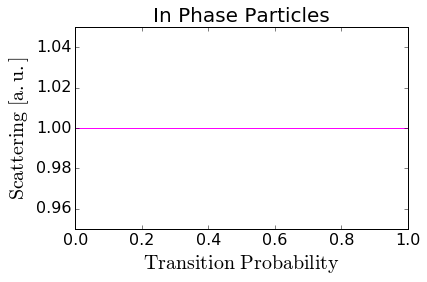

In [353]:
fig = plt.figure(figsize=(8, 6), dpi=300);

x = arange(0, 1.005, 0.005);
y = [scatter(1.0, 1.0, p, 100, 200.0, 600.0, 100) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
#axes1.set_ylim(0.1, 0.8);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( 'In Phase Particles',        size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);

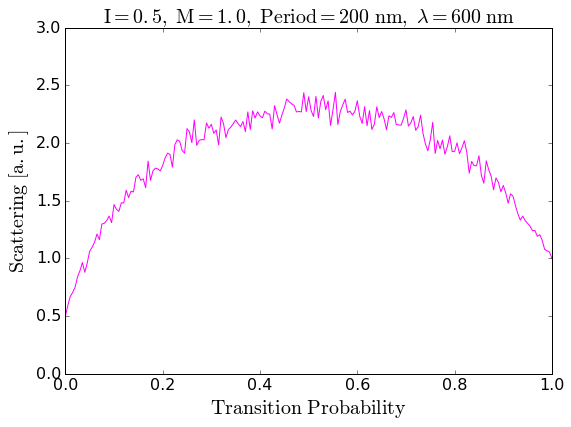

In [6]:
fig = plt.figure(figsize=(8, 6), dpi=300);

x = arange(0, 1.005, 0.005);
y = [scatter(0.5, 1.0, p, 100, 200.0, 600.0, 250) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0.0, 3.0);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( '$\mathrm{I=0.5,\ M = 1.0,\ Period=200\ nm,\ \lambda =600\ nm}$',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Subwavelength_InPhase.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Subwavelength_InPhase.svg', bbox_inches='tight', dpi=300);

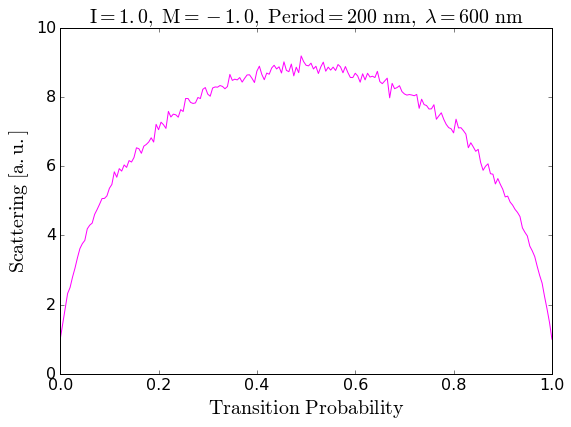

In [8]:
fig = plt.figure(figsize=(8, 6), dpi=300);

x = arange(0, 1.005, 0.005);
y = [scatter(1.0, -1.0, p, 100, 200.0, 600.0, 1000) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0, 10);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( '$\mathrm{I=1.0,\ M = -1.0,\ Period=200\ nm,\ \lambda =600\ nm}$',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Subwavelength_OutOfPhase.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Subwavelength_InPhase.svg', bbox_inches='tight', dpi=300);

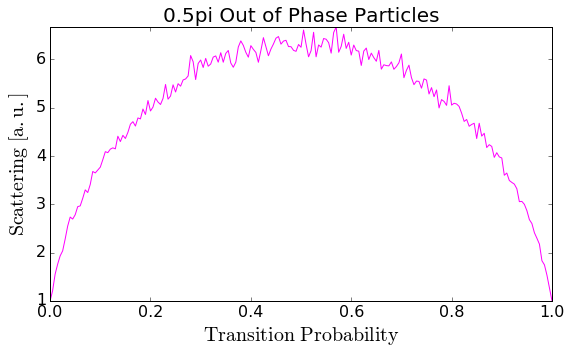

In [351]:
fig = plt.figure(figsize=(8, 6), dpi=300);

I = complex(1,1)/abs(complex(1,1));
M = complex(1,-1)/abs(complex(1,-1));

x = arange(0, 1.005, 0.005);
y = [scatter(I, M, p, 100, 200.0, 600.0, 500) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0.0, 0.7);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( '0.5pi Out of Phase Particles',size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);

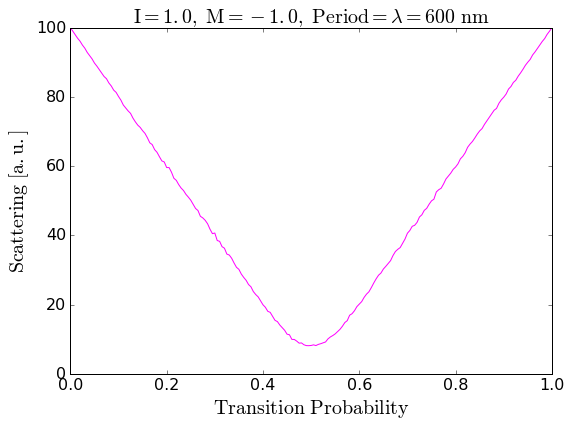

In [9]:
fig = plt.figure(figsize=(8, 6), dpi=300);

x = arange(0, 1.005, 0.005);
y = [scatter(1.0, -1.0, p, 100, 600.0, 600.0, 1000) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0, 100);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( '$\mathrm{I=1.0,\ M = -1.0,\ Period=\lambda = 600\ nm}$',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Grating_OutOfPhase.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Grating_OutOfPhase.svg', bbox_inches='tight', dpi=300);

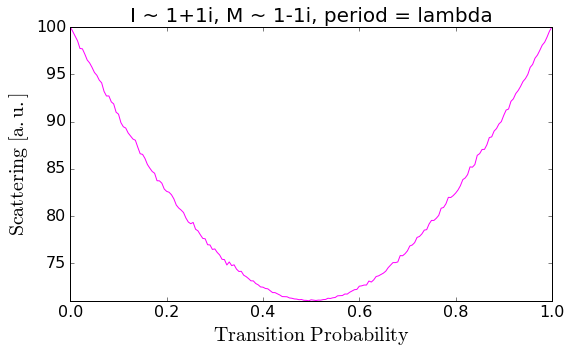

In [357]:
fig = plt.figure(figsize=(8, 5), dpi=300);

I = complex(1,1)/abs(complex(1,1));
M = complex(1,-1)/abs(complex(1,-1));

x = arange(0, 1.005, 0.005);
y = [scatter(I, M, p, 100, 600.0, 600.0, 250) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0, 100);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( '$\mathrm{I~1+1i,\ M~1-1i,\ Period=\lambda = 600\ nm}$',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);

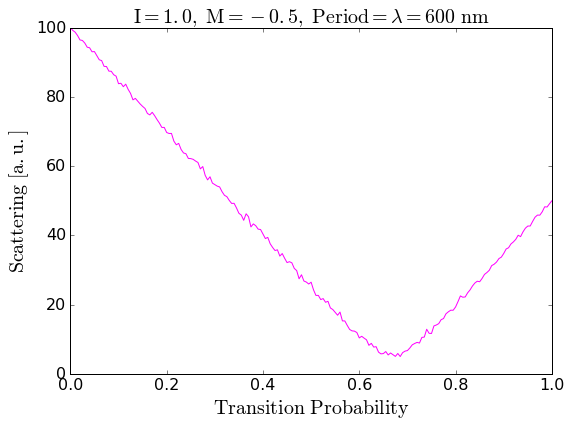

In [10]:
fig = plt.figure(figsize=(8, 6), dpi=300);

x = arange(0, 1.005, 0.005);
y = [scatter(1.0, -0.5, p, 100, 600.0, 600.0, 100) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0, 100);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( '$\mathrm{I=1.0,\ M = -0.5,\ Period=\lambda = 600\ nm}$',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Grating_OutOfPhase_UnequalAmplitude.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_10_STOCHASTIC_ARRAYS/Grating_OutOfPhase_UnequalAmplitude.svg', bbox_inches='tight', dpi=300);

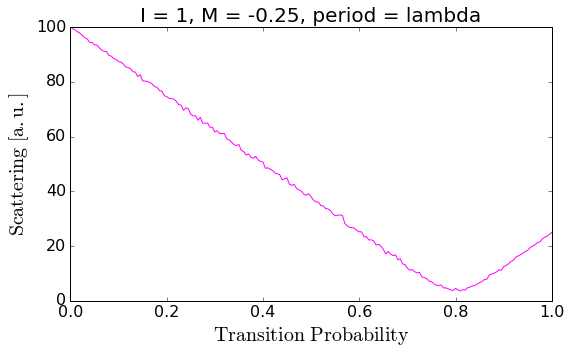

In [359]:
fig = plt.figure(figsize=(8, 5), dpi=300);

x = arange(0, 1.005, 0.005);
y = [scatter(1.0, -0.25, p, 100, 600.0, 600.0, 100) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
axes1.set_ylim(0, 100);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( 'I = 1, M = -0.25, period = lambda',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);

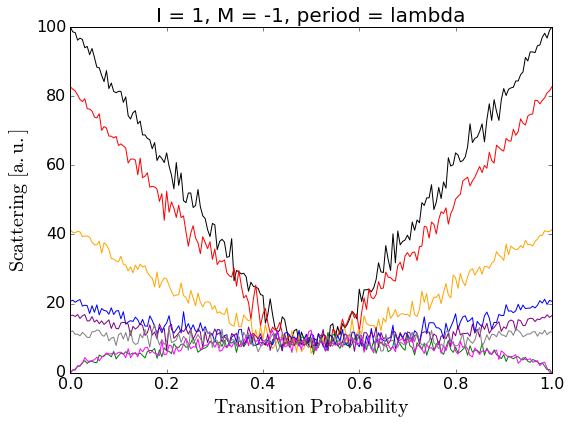

In [371]:
fig = plt.figure(figsize=(8, 6), dpi=300);

x = arange(0, 1.005, 0.005);

y0 = [scatter(1.0, -1.0, p, 100, 614.0, 600.0, 10) for p in x];
y1 = [scatter(1.0, -1.0, p, 100, 612.0, 600.0, 10) for p in x];
y2 = [scatter(1.0, -1.0, p, 100, 610.0, 600.0, 10) for p in x];
y3 = [scatter(1.0, -1.0, p, 100, 608.0, 600.0, 10) for p in x];
y4 = [scatter(1.0, -1.0, p, 100, 606.0, 600.0, 10) for p in x];
y5 = [scatter(1.0, -1.0, p, 100, 604.0, 600.0, 10) for p in x];
y6 = [scatter(1.0, -1.0, p, 100, 602.0, 600.0, 10) for p in x];
y7 = [scatter(1.0, -1.0, p, 100, 600.0, 600.0, 10) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y7, 'black',   linewidth = 1);
axes1.plot(x, y6, 'red',     linewidth = 1);
axes1.plot(x, y5, 'orange',  linewidth = 1);
axes1.plot(x, y4, 'green',   linewidth = 1);
axes1.plot(x, y3, 'blue',    linewidth = 1);
axes1.plot(x, y2, 'purple',  linewidth = 1);
axes1.plot(x, y1, 'magenta', linewidth = 1);
axes1.plot(x, y0, 'grey',    linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
#axes1.set_ylim(0.1, 0.8);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
axes1.set_title( 'I = 1, M = -1, period = lambda',      size=20);
axes1.set_xlabel('$\mathrm{Transition\ Probability}$',  size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);

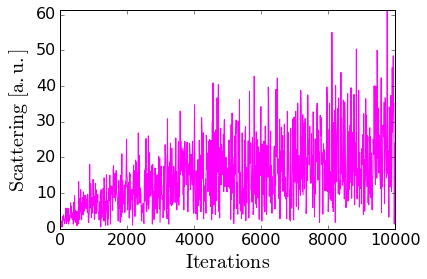

In [306]:
fig = plt.figure(figsize=(6, 4), dpi=300);

x = arange(0, 10010, 10);
y = [abs(scatter(0.5, 1.0, 0.5, p, 100.0, 600.0)) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
#axes1.set_ylim(0.1, 0.8);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
#axes1.set_title('$\mathrm{Single\ Crystal\ VO_{2}\ Reflectivity}$',size=20);
axes1.set_xlabel('$\mathrm{Iterations}$', size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);

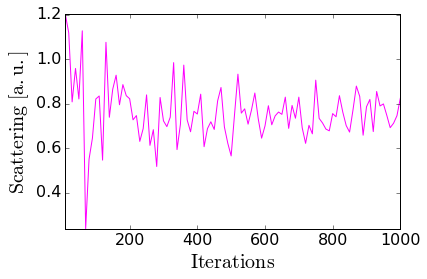

In [312]:
fig = plt.figure(figsize=(6, 4), dpi=300);

x = arange(0, 1010, 10);
y = [abs(scatter(0.5, 1.0, 0.5, 100, 200.0, 600.0, p)) for p in x];

#######################
### Define Figure 1 ###
#######################

axes1 = fig.add_subplot(111); 

axes1.plot(x, y, 'magenta', linewidth = 1);

axes1.axis('tight');
#axes1.set_xlim(1.0, 3.0);
#axes1.set_ylim(0.1, 0.8);

axes1.tick_params(axis = 'both', which = 'major', labelsize = 16);
#axes1.grid(True);
#axes1.set_title('$\mathrm{Single\ Crystal\ VO_{2}\ Reflectivity}$',size=20);
axes1.set_xlabel('$\mathrm{Iterations}$', size=20);
axes1.set_ylabel('$\mathrm{Scattering\ [a.u.]}$',       size=20);

#axes1.legend(["Insulator", "Metallic",], prop={'size': 16}, bbox_to_anchor=(0.57, 1.00));

#t1 = axes1.text(0.02, 1.05, '(a)', color='black', fontsize=22, transform=axes1.transAxes);

#####################
### Export Figure ###
#####################

fig.tight_layout();

#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.png', bbox_inches='tight', dpi=300);
#fig.savefig('figures/2016_09_PAPER_VO2_RESONATORS_v1/FIGURE_1_SingleCrystal_Reflectivity_Permittivity.svg', bbox_inches='tight', dpi=300);